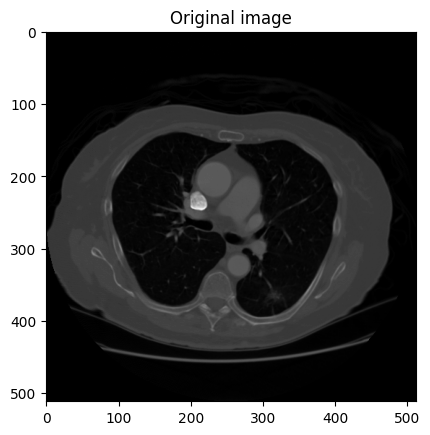

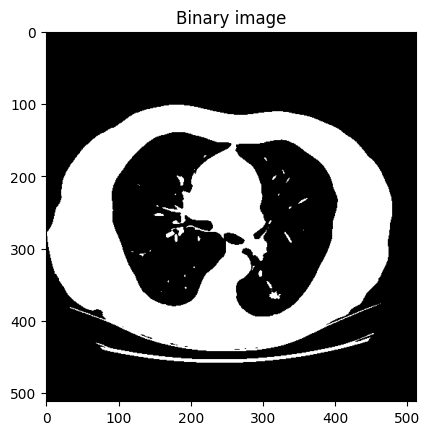

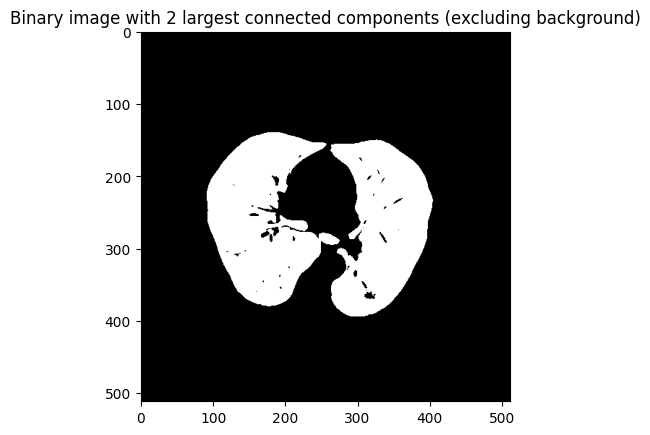

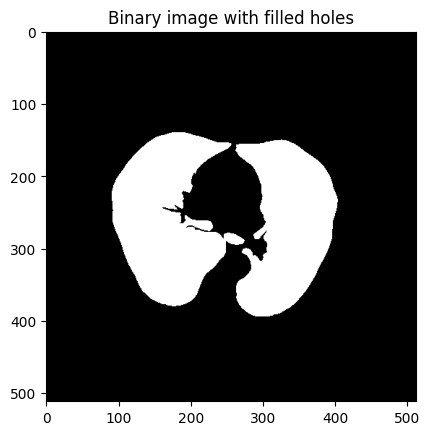

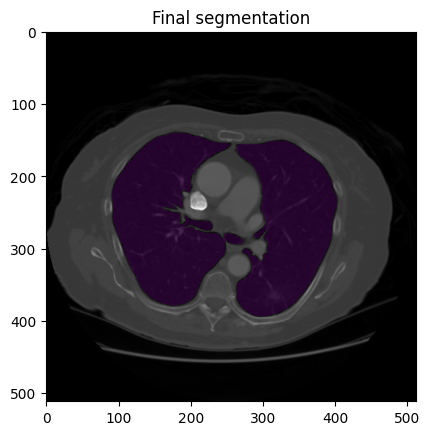

/var/folders/dv/2dpvhcy95qq29g3502cyk9cc0000gn/T/ipykernel_25899/4055293972.py:54: RuntimeWarning: invalid value encountered in cast
  props = regionprops(binary.astype(int))


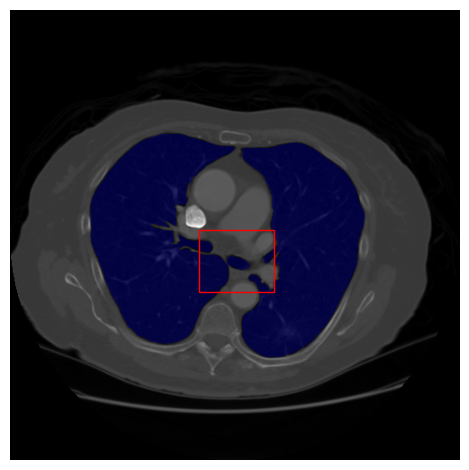

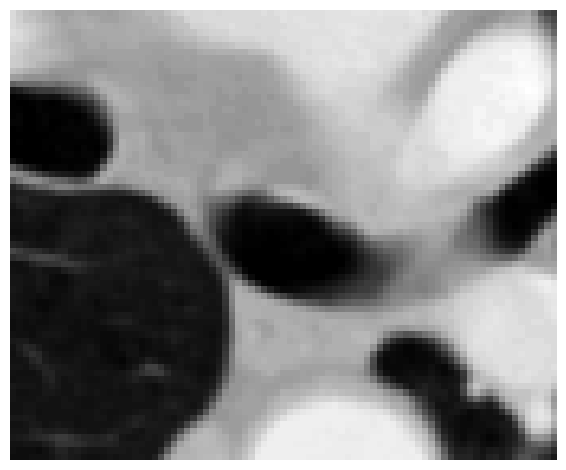

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops
import numpy as np
from scipy.ndimage import label, binary_fill_holes
def segment_lungs(image):
    # Visualise original image.
    plt.imshow(image, cmap="gray")
    plt.title("Original image")
    plt.show()

    # Apply an Otus threshold.
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    plt.imshow(binary, cmap="gray")
    plt.title("Binary image")
    plt.show()

    # Keep 2nd and 3rd largest connected components.
    label_image, _ = label(~binary)
    regions = regionprops(label_image)
    regions.sort(key=lambda x: x.area, reverse=True)
    binary = np.zeros_like(binary)

    # Avoid largest connected component (background).
    binary[label_image == regions[1].label] = 1
    binary[label_image == regions[2].label] = 1

    plt.imshow(binary, cmap="gray")
    plt.title("Binary image with 2 largest connected components (excluding background)")
    plt.show()

    # Fill holes.
    binary = binary_fill_holes(binary)

    plt.imshow(binary, cmap="gray")
    plt.title("Binary image with filled holes")
    plt.show()

    # Visualise the final segmentation over the original image.
    plt.imshow(image, cmap="gray")
    binary = binary.astype(float)
    binary[binary == 0] = np.nan  # Only show the segmented regions.
    plt.imshow(binary, alpha=0.5)
    plt.title("Final segmentation")
    plt.show()
    
    # Plotting both original and segmented images with bounding box
    
    # Plot original image with final segmentation mask overlay
    plt.imshow(image, cmap='gray')
    plt.imshow(binary, alpha=0.5, cmap='jet')  # Overlay segmentation mask with transparency
    props = regionprops(binary.astype(int))
    bbox = props[0].bbox  # Get bounding box for the largest segmented area
    bbox = (250, 215, 320, 300)
    rect = plt.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('q1a_seg_w_bbox.png', dpi=300, bbox_inches='tight')
    plt.show()
    # Plot zoomed region as indicated by bounding box on the right side
    zoomed_region = image[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    plt.imshow(zoomed_region, cmap='gray')
    plt.axis('off')
    plt.savefig('q1a_zoomed_region.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    return binary
    
    
image_path = "../data/CT.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
segment_lungs(image)



In [65]:
import numpy as np
import matplotlib.pyplot as plt


def create_rgb_mask(binary_mask):
    # Create an all-white RGB image of the same dimensions as the binary mask
    height, width = binary_mask.shape
    rgb_mask = (
        np.ones((height, width, 3), dtype=np.uint8) * 255
    )  # Multiply by 255 to make it white

    # Where the binary mask is 1, set the RGB mask to black
    rgb_mask[binary_mask == 1] = [0, 0, 0]  # Set to black

    return rgb_mask


def segment_flowers(image):
    from skimage import io, restoration, color

    # Visualise original image.
    plt.imshow(image)
    plt.title("RGB Image")
    plt.axis("off")
    plt.show()

    # Apply a guassian blur to denoise the image.
    denoised_image = restoration.denoise_bilateral(
        image, win_size=5, sigma_color=0.5, sigma_spatial=15, channel_axis=-1
    )

    plt.imshow(denoised_image)
    plt.title("Denoised Image")
    plt.axis("off")
    plt.show()


    # Use LAB colour space for clustering.
    image_lab = color.rgb2lab(denoised_image)
    pixels = image_lab.reshape((-1, 3))

    # Create the KMeans model
    kmeans = KMeans(n_clusters=5)

    # Fit the KMeans model
    kmeans.fit(pixels)

    # Get the cluster assignments
    cluster_assignments = kmeans.labels_

    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_

    # Reshape the cluster assignments to an image
    cluster_image = cluster_assignments.reshape(image_lab.shape[:2])

    # LAB value for purple (source: https://www.e-paint.co.uk/lab-hlc-rgb-lrv-values.asp?cRange=BS+5252&cRef=02+D+45&cDescription=Purple)
    purple = [34.64, 34.45, -4.07]

    # Find the cluster center that is closest to purple.
    closest_cluster_index = np.argmin(np.linalg.norm(cluster_centers - purple, axis=1))

    # Get the mask for the purple cluster.
    mask = (cluster_image == closest_cluster_index)

    # Perform opening with a ball of radius 2 to disconnect small regions.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)

    # Visualise the mask
    plt.imshow(mask, cmap="gray")
    plt.title("K Means Mask")
    plt.axis("off")
    plt.show()

    # Keep only connected components with area greater than 100 pixels.
    label_image, _ = label(mask)
    regions = regionprops(label_image)
    mask = np.zeros_like(mask)
    for region in regions:
        if region.area > 100:
            mask[label_image == region.label] = 1

    
    plt.imshow(mask, cmap="gray")
    plt.title("Cleaned Mask")
    plt.axis("off")
    plt.show()

    # Visualise the mask over the original image.
    rgb_mask = create_rgb_mask(mask)
    rgb_mask = rgb_mask.astype(float)
    rgb_mask[rgb_mask == 0] = np.nan  # Set black to transparent.

    # Normalise the mask to avoid clipping when overlaying.
    rgb_mask /= 255.0

    plt.imshow(image)
    plt.imshow(
        rgb_mask, cmap="jet", alpha=0.5
    )  # Use a colormap with good contrast, 'jet' for example
    plt.title("Mask Overlay")
    plt.axis("off")
    plt.show()
    
    return rgb_mask

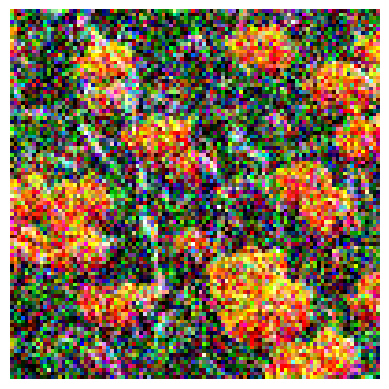

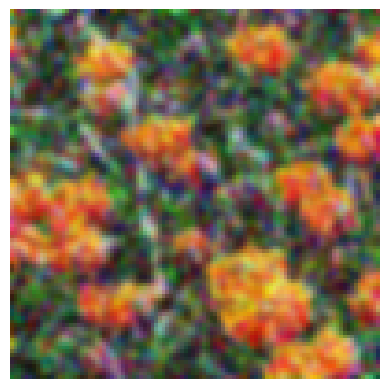

In [57]:
from skimage import io, restoration, color
from sklearn.cluster import KMeans
# Import gaussian filter
from skimage.filters import gaussian

image_path = "../data/noisy_flower.jpg"
image = io.imread(image_path)

# Zoom in on the center of the image
patch = image[200:300, 200:300]
plt.imshow(patch)
plt.axis("off")
plt.savefig('q1b_patch.png', dpi=300, bbox_inches='tight')
plt.show()

# Apply a guassian blur to denoise the image.
blurry_patch = gaussian(patch, sigma=1, channel_axis=-1)
plt.imshow(blurry_patch)
plt.axis("off")
# plt.savefig('q1b_gauss_blurred_patch.png', dpi=300, bbox_inches='tight')
plt.show()

# convert image to lab color space
blurry_patch = restoration.denoise_bilateral(
    patch, win_size=5, sigma_color=1, sigma_spatial=100, channel_axis=-1
)
plt.imshow(blurry_patch)
plt.axis("off")
# plt.savefig('q1b_gauss_blurred_patch.png', dpi=300, bbox_inches='tight')
plt.show()





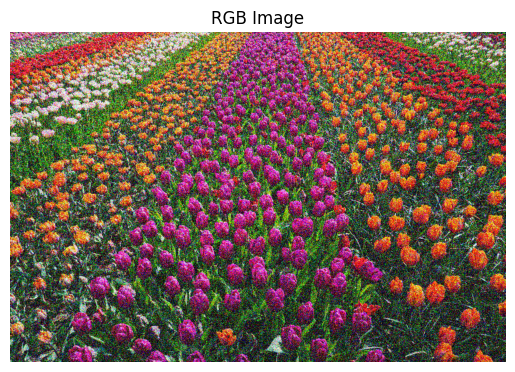

/Users/vishaljain/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


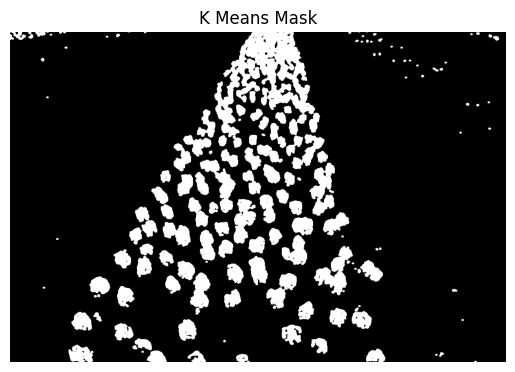

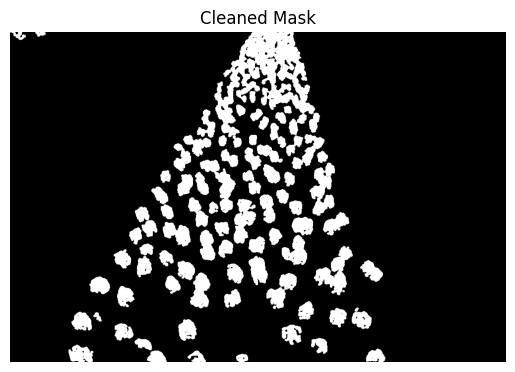

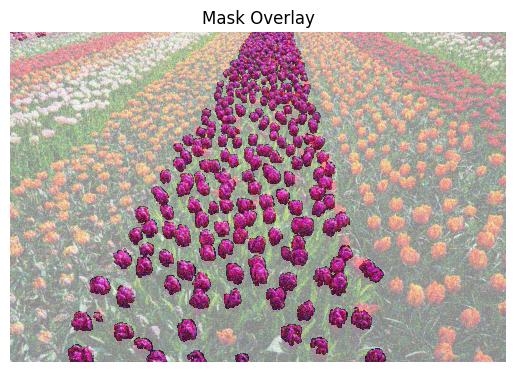

In [66]:
from skimage import io, restoration, color
from sklearn.cluster import KMeans
# Import gaussian filter
from skimage.filters import gaussian

image_path = "../data/noisy_flower.jpg"
image = io.imread(image_path)
# RGBA -> RGB since alpha=255 everywhere.
image = image[:, :, :3]
mask = segment_flowers(image)



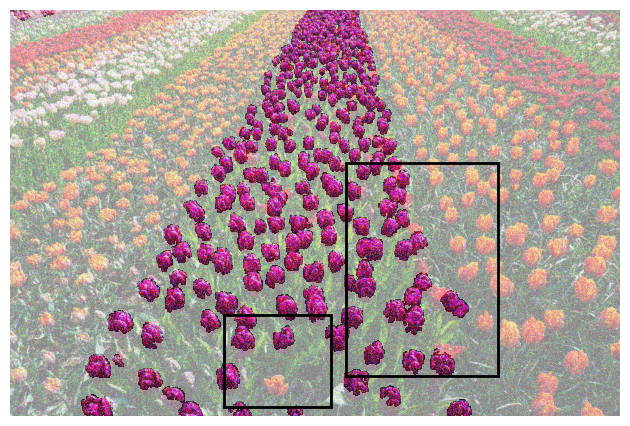

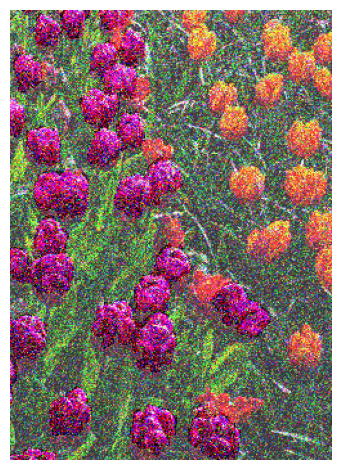

In [86]:
 # Plot original image with final segmentation mask overlay
plt.imshow(image, cmap='gray')
plt.imshow(mask, alpha=0.5, cmap='jet')  # Overlay segmentation mask with transparency

# Define bounding boxes 
bbox1 = (500, 350, 650, 525)
bbox2 = (250, 550, 600, 800)

rect1 = plt.Rectangle((bbox1[1], bbox1[0]), bbox1[3] - bbox1[1], bbox1[2] - bbox1[0], linewidth=2, edgecolor='k', facecolor='none')
rect = plt.Rectangle((bbox2[1], bbox2[0]), bbox2[3] - bbox2[1], bbox2[2] - bbox2[0], linewidth=2, edgecolor='k', facecolor='none')

# Draw bounding boxes
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect)
plt.axis('off') 
plt.tight_layout()
plt.savefig('q1b_seg_w_good_bbox.png', dpi=300, bbox_inches='tight')
plt.show()


# Plot zoomed region as indicated by bounding box on the right side
zoomed_region1 = image[bbox1[0]:bbox1[2], bbox1[1]:bbox1[3]]
plt.imshow(zoomed_region1, cmap='gray')
plt.imshow(mask[bbox1[0]:bbox1[2], bbox1[1]:bbox1[3]], alpha=0.2, cmap='jet')  # Overlay segmentation mask with transparency
plt.axis('off')
plt.tight_layout()
plt.savefig('q1b_good_zoomed_region.png', dpi=300, bbox_inches='tight')
plt.show()

zoomed_region2 = image[bbox2[0]:bbox2[2], bbox2[1]:bbox2[3]]
plt.imshow(zoomed_region2, cmap='gray')
plt.imshow(mask[bbox2[0]:bbox2[2], bbox2[1]:bbox2[3]], alpha=0.2, cmap='jet')  # Overlay segmentation mask with transparency
plt.axis('off')
plt.tight_layout()
plt.savefig('q1b_good_zoomed_region2.png', dpi=300, bbox_inches='tight')
plt.show()





In [98]:
plt.imshow(image, cmap='gray')
plt.imshow(mask, alpha=0.5, cmap='jet')  # Overlay segmentation mask with transparency
bbox1 = (500, 150, 660, 750)
rect = plt.Rectangle((bbox1[1], bbox1[0]), bbox1[3] - bbox1[1], bbox1[2] - bbox1[0], linewidth=2, edgecolor='k', facecolor='none')
plt.gca().add_patch(rect)
plt.gca().add_patch(rect)
plt.axis('off')
plt.tight_layout()
plt.savefig('q1b_seg_w_bad_bbox.png', dpi=300, bbox_inches='tight')
plt.show()


# Plot zoomed region as indicated by bounding box on the right side
zoomed_region1 = image[bbox1[0]:bbox1[2], bbox1[1]:bbox1[3]]
plt.imshow(zoomed_region1, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig('q1b_bad_zoomed_region.png', dpi=300, bbox_inches='tight')
plt.show()


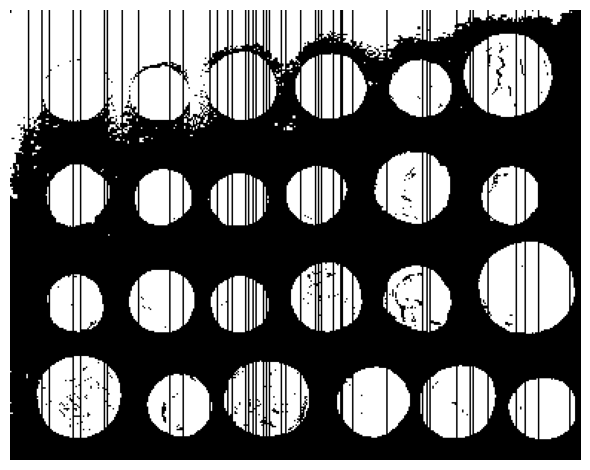

In [106]:
image_path = "../data/coins.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Apply an Otus threshold.
_, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply canny edge detection to compare with the binary image.
edges = cv2.Canny(image, 100, 150)


plt.imshow(binary, cmap="gray")
plt.axis("off")
plt.tight_layout()

plt.savefig('figs/q1c_otsu_thresholded.png', dpi=300, bbox_inches='tight')
plt.show()

plt.imshow(edges, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()
